#Required modules

In [1]:
# Needed modules
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import *
from tqdm import tqdm


use_cuda = True

In [2]:
!unzip serverside.zip
#get from trevor 

Archive:  serverside.zip
   creating: serverside/
  inflating: serverside/.gitignore   
  inflating: serverside/.travis.yml  
  inflating: serverside/appveyor.yml  
   creating: serverside/captcha/
  inflating: serverside/captcha/audio.py  
   creating: serverside/captcha/data/
   creating: serverside/captcha/data/0/
  inflating: serverside/captcha/data/0/default.wav  
   creating: serverside/captcha/data/1/
  inflating: serverside/captcha/data/1/default.wav  
   creating: serverside/captcha/data/2/
  inflating: serverside/captcha/data/2/default.wav  
   creating: serverside/captcha/data/3/
  inflating: serverside/captcha/data/3/default.wav  
   creating: serverside/captcha/data/4/
  inflating: serverside/captcha/data/4/default.wav  
   creating: serverside/captcha/data/5/
  inflating: serverside/captcha/data/5/default.wav  
   creating: serverside/captcha/data/6/
  inflating: serverside/captcha/data/6/default.wav  
   creating: serverside/captcha/data/7/
  inflating: serverside/captch

In [3]:
pip install pillow-lut

  Created wheel for pillow-lut: filename=pillow_lut-1.0-py3-none-any.whl size=9600 sha256=c7e3236f40590b779831aff2a20eec72abb16744174b9ce011640bfe91e6cefb
  Stored in directory: /root/.cache/pip/wheels/0b/6d/48/ced81964abea77cb058888839344e6fbe9936bfcd40d26c40b
Successfully built pillow-lut


In [4]:
from serverside.captcha.image import ImageCaptcha
from tqdm import tqdm
import os
import string
import random

# Dataset Generation


In [5]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = "abcdefghjkmnopqrstuvwxyz" + "ABCDEFGHIJKLMNOPQRSTUVWXYZ" + "123456789" + "     "
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [6]:
from torchvision.transforms.transforms import Grayscale
# Load datasets
# Label formated as 2D tensor of indexed as [place][tokenID]
chars = "abcdefghijklmnopqrstuvwxyz123456789 " # use " " as null character. Leave out o and 0, also case insensitive
charIndex = {}
for i, char in enumerate(chars):
    charIndex[char] = i

idn = torch.eye(len(chars)).cuda()

def strToOH(string):
    oneHot = []
    for char in string:
      oneHot.append(idn[charIndex[char]])
    return torch.stack(oneHot)

def strToInd(string):
    oneHot = []
    for char in string:
      oneHot.append(torch.tensor(charIndex[char]))
    return torch.stack(oneHot)

In [7]:
class TCacheSet():
    def __init__(self, size, period):
        self.size = size
        self.cached = []
        self.period = period
        self.IC = ImageCaptcha(width = 25)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush()
    def flush(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(1)
            data = self.IC.generate_image(label)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (1 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1]

    def __len__(self):
        return self.size

class TFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.period = size
        self.IC = ImageCaptcha(width = 25) # specify width to be 25, and then it will be resized to 224
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(1)
            data = self.IC.generate_image(label)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (1 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1]

    def __len__(self):
        return self.size

In [8]:
trainDataT = TCacheSet(12800, 1280)
valDataT = TFrozenSet(3000)

# Model and Training


It will be fed 224x224 images so i can reuse trevor's script

In [17]:
class nn_captcha(nn.Module):
    def __init__(self):
        super(nn_captcha, self).__init__()
        self.name = "res_cap"
        self.conv1 = nn.Conv2d(3, 10, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(53*53*10, 500)  #width*height will change depending on previous layers, pooling, and the initial dimensions of the photo
        self.fc2 = nn.Linear(500, 36)       # there are 36 possible characters, 26 letters (A-Z) and 10 digits (0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, len(chars), 1)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [10]:
do_cuda = True

def get_accuracy1(model, train=False, batch_size = 64):
    if train:
        data = trainDataT
    else:
        data = valDataT

    correct = 0
    total = 0
    for imgs, labels in tqdm(torch.utils.data.DataLoader(data, batch_size=batch_size)):
        if use_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()
          #pass

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train_small(model, data, batch_size=64, num_epochs=30, learning_rate=0.0001):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []


    startTime = time.time() # to see how long training goes
    print("starting training")
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        
        try:
            data.flush()
            train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        except Exception:
            pass
        print("epoch: ", epoch)
        for imgs, labels in tqdm(iter(train_loader)):
            #print(labels.shape)
            if do_cuda and torch.cuda.is_available:
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            #print(out[0])
            #print()
            #print(labels[0])
            #print()
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1

        #train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy1(model, train=False, batch_size=batch_size))  # compute validation accuracy
        print(("Epoch {}: |"+"Validation acc: {}").format(
                epoch, # call epoch zero epoch zero
                
                val_acc[-1]))
        
        #checkpoint
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), path)


    
    finishTime = time.time()

    delta = finishTime - startTime
    print("\nDONE TRAINING in %s seconds!\n" % delta)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    #plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    

True
starting training
epoch:  0


100%|██████████| 47/47 [00:01<00:00, 40.95it/s]


Epoch 0: |Validation acc: 0.25466666666666665
epoch:  1


100%|██████████| 47/47 [00:01<00:00, 41.09it/s]


Epoch 1: |Validation acc: 0.331
epoch:  2


100%|██████████| 47/47 [00:01<00:00, 41.25it/s]


Epoch 2: |Validation acc: 0.36133333333333334
epoch:  3


100%|██████████| 47/47 [00:01<00:00, 41.61it/s]


Epoch 3: |Validation acc: 0.38766666666666666
epoch:  4


100%|██████████| 47/47 [00:01<00:00, 41.30it/s]


Epoch 4: |Validation acc: 0.4083333333333333
epoch:  5


100%|██████████| 47/47 [00:01<00:00, 41.75it/s]


Epoch 5: |Validation acc: 0.411
epoch:  6


100%|██████████| 47/47 [00:01<00:00, 41.05it/s]


Epoch 6: |Validation acc: 0.43433333333333335
epoch:  7


100%|██████████| 47/47 [00:01<00:00, 41.17it/s]


Epoch 7: |Validation acc: 0.42833333333333334
epoch:  8


100%|██████████| 47/47 [00:01<00:00, 41.55it/s]


Epoch 8: |Validation acc: 0.44533333333333336
epoch:  9


100%|██████████| 47/47 [00:01<00:00, 41.47it/s]


Epoch 9: |Validation acc: 0.4776666666666667
epoch:  10


100%|██████████| 47/47 [00:01<00:00, 41.58it/s]


Epoch 10: |Validation acc: 0.473
epoch:  11


100%|██████████| 47/47 [00:01<00:00, 41.59it/s]


Epoch 11: |Validation acc: 0.4796666666666667
epoch:  12


100%|██████████| 47/47 [00:01<00:00, 41.59it/s]


Epoch 12: |Validation acc: 0.4826666666666667
epoch:  13


100%|██████████| 47/47 [00:01<00:00, 41.13it/s]


Epoch 13: |Validation acc: 0.492
epoch:  14


100%|██████████| 47/47 [00:01<00:00, 41.76it/s]


Epoch 14: |Validation acc: 0.513
epoch:  15


100%|██████████| 47/47 [00:01<00:00, 42.41it/s]


Epoch 15: |Validation acc: 0.49933333333333335
epoch:  16


100%|██████████| 47/47 [00:01<00:00, 41.34it/s]


Epoch 16: |Validation acc: 0.5133333333333333
epoch:  17


100%|██████████| 47/47 [00:01<00:00, 41.52it/s]


Epoch 17: |Validation acc: 0.526
epoch:  18


100%|██████████| 47/47 [00:01<00:00, 41.92it/s]


Epoch 18: |Validation acc: 0.5116666666666667
epoch:  19


100%|██████████| 47/47 [00:01<00:00, 41.65it/s]


Epoch 19: |Validation acc: 0.53
epoch:  20


100%|██████████| 47/47 [00:01<00:00, 41.60it/s]


Epoch 20: |Validation acc: 0.535
epoch:  21


100%|██████████| 47/47 [00:01<00:00, 42.16it/s]


Epoch 21: |Validation acc: 0.523
epoch:  22


100%|██████████| 47/47 [00:01<00:00, 41.99it/s]


Epoch 22: |Validation acc: 0.5286666666666666
epoch:  23


100%|██████████| 47/47 [00:01<00:00, 41.66it/s]


Epoch 23: |Validation acc: 0.5216666666666666
epoch:  24


100%|██████████| 47/47 [00:01<00:00, 41.05it/s]


Epoch 24: |Validation acc: 0.5276666666666666
epoch:  25


100%|██████████| 47/47 [00:01<00:00, 41.36it/s]


Epoch 25: |Validation acc: 0.527
epoch:  26


100%|██████████| 47/47 [00:01<00:00, 39.86it/s]


Epoch 26: |Validation acc: 0.54
epoch:  27


100%|██████████| 47/47 [00:01<00:00, 41.53it/s]


Epoch 27: |Validation acc: 0.5266666666666666
epoch:  28


100%|██████████| 47/47 [00:01<00:00, 41.89it/s]


Epoch 28: |Validation acc: 0.5303333333333333
epoch:  29


100%|██████████| 47/47 [00:01<00:00, 41.50it/s]


Epoch 29: |Validation acc: 0.557
epoch:  30


100%|██████████| 47/47 [00:01<00:00, 41.66it/s]


Epoch 30: |Validation acc: 0.5543333333333333
epoch:  31


100%|██████████| 47/47 [00:01<00:00, 41.71it/s]


Epoch 31: |Validation acc: 0.5503333333333333
epoch:  32


100%|██████████| 47/47 [00:01<00:00, 41.76it/s]


Epoch 32: |Validation acc: 0.5553333333333333
epoch:  33


100%|██████████| 47/47 [00:01<00:00, 41.23it/s]


Epoch 33: |Validation acc: 0.5773333333333334
epoch:  34


100%|██████████| 47/47 [00:01<00:00, 41.49it/s]


Epoch 34: |Validation acc: 0.572
epoch:  35


100%|██████████| 47/47 [00:01<00:00, 41.59it/s]


Epoch 35: |Validation acc: 0.565
epoch:  36


100%|██████████| 47/47 [00:01<00:00, 41.57it/s]


Epoch 36: |Validation acc: 0.5673333333333334
epoch:  37


100%|██████████| 47/47 [00:01<00:00, 41.69it/s]


Epoch 37: |Validation acc: 0.5783333333333334
epoch:  38


100%|██████████| 47/47 [00:01<00:00, 41.76it/s]


Epoch 38: |Validation acc: 0.591
epoch:  39


100%|██████████| 47/47 [00:01<00:00, 42.23it/s]


Epoch 39: |Validation acc: 0.5656666666666667
epoch:  40


100%|██████████| 47/47 [00:01<00:00, 41.38it/s]


Epoch 40: |Validation acc: 0.572
epoch:  41


100%|██████████| 47/47 [00:01<00:00, 41.63it/s]


Epoch 41: |Validation acc: 0.577
epoch:  42


100%|██████████| 47/47 [00:01<00:00, 41.97it/s]


Epoch 42: |Validation acc: 0.588
epoch:  43


100%|██████████| 47/47 [00:01<00:00, 41.77it/s]


Epoch 43: |Validation acc: 0.589
epoch:  44


100%|██████████| 47/47 [00:01<00:00, 42.01it/s]


Epoch 44: |Validation acc: 0.5736666666666667
epoch:  45


100%|██████████| 47/47 [00:01<00:00, 42.15it/s]


Epoch 45: |Validation acc: 0.5746666666666667
epoch:  46


100%|██████████| 47/47 [00:01<00:00, 41.45it/s]


Epoch 46: |Validation acc: 0.5793333333333334
epoch:  47


100%|██████████| 47/47 [00:01<00:00, 42.25it/s]


Epoch 47: |Validation acc: 0.5883333333333334
epoch:  48


100%|██████████| 47/47 [00:01<00:00, 42.30it/s]


Epoch 48: |Validation acc: 0.584
epoch:  49


100%|██████████| 47/47 [00:01<00:00, 41.86it/s]


Epoch 49: |Validation acc: 0.6023333333333334

DONE TRAINING in 1686.8532478809357 seconds!



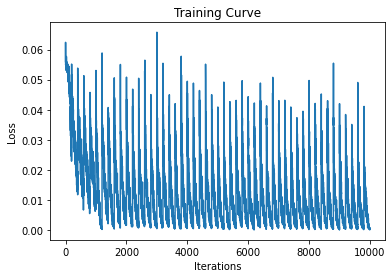

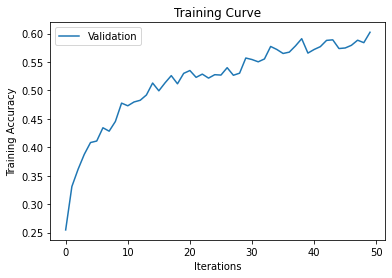

Final Validation Accuracy: 0.6023333333333334


In [18]:
model3 = nn_captcha()
#state = torch.load("/content/gdrive/MyDrive/APS360Project_Dataset/training_checkpoints/model_res_cap_bs64_lr0.0001_epoch40")
#model2.load_state_dict(state)
print(torch.cuda.is_available())
model3.cuda()
train_small(model3,  trainDataT, num_epochs = 50, learning_rate = 0.001)

# Generate Distribution

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


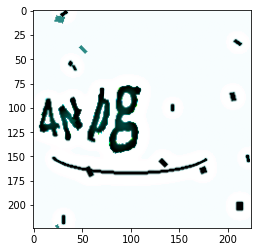

In [22]:
img = plt.imread('/content/gdrive/MyDrive/APS360Project_Dataset/testing_stuff/4npg.png')
plt.imshow(img)

(224, 224, 3)


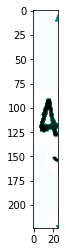

In [23]:
window_w = 25  # can be changed
#img_to_tensor = transforms.ToTensor()
#img2 = img_to_tensor(img)
img2 = np.array(img)
print(img2.shape)
img_c = img2[:,:window_w,:]
plt.imshow(img_c)

In [24]:
c_w = torch.from_numpy(img_c).shape[1]
c_h = torch.from_numpy(img_c).shape[0]
print(("shape is: {}x{}").format(c_w, c_h))

shape is: 25x224


In [25]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [26]:
img_windows = []
captcha_w = img2.shape[1]
transf = transforms.Resize((224, 224))
      
for i in range(0,captcha_w - window_w):
    #print(c_w)
    new_img = img2[:,i:(window_w+i),:]
    if window_w != 224:
        #new_img = transf(new_img)
        #new_img = cv2.resize(new_img, (0,0 ), fx=224/window_w, fy=224/c_h)
        #print(new_img.shape)


        #new_img = np.tile(new_img, (1,9,1))
        #new_img = new_img[:,:224,:]

        #print(new_img.shape)
        new_img = cv2.resize(new_img, (0,0 ), fx=224/window_w, fy=224/c_h)
    img_windows.append(new_img)

In [27]:
img_to_tensor = transforms.ToTensor()
for i in range(0, len(img_windows)):
    img_windows[i] = img_to_tensor(np.array(img_windows[i]))

print(img_windows[0].shape)

torch.Size([3, 224, 224])


In [28]:
for i in range(0, len(img_windows)):
    img_windows[i] = img_windows[i].unsqueeze(0)

In [29]:
model3.cuda()

nn_captcha(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=36, bias=True)
)

This will output a plot of the probability distribution across the image

total prob is: tensor([1.], device='cuda:0', grad_fn=<AddBackward0>)
tensor(100)


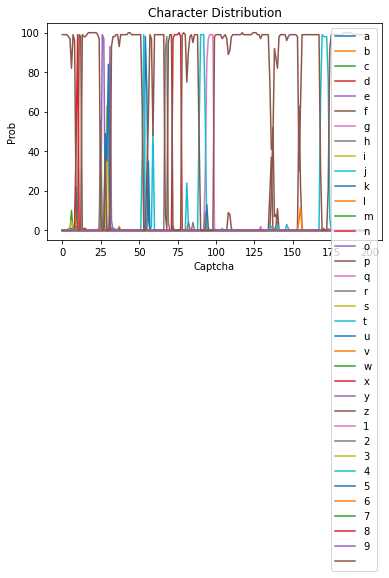

In [31]:
#will store the probabilities 
distribution = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
distribution = np.array(distribution)

#dist_nosm = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
#dist_nosm = np.array(dist_nosm)

iter1 = 0
prob_sum = 0
for k in range(0, len(img_windows)): # for each window
    img_windows[k] = img_windows[k].cuda()
    pred = model3(img_windows[k])  #pred has shape 1x35 (will change to 36 once null is added)
    #print(len(pred[0]))
    for j in range(0, 36): # for each class
        #print(("k: {} | j: {}").format(k, j))
        
        pred2 = torch.softmax(pred, dim=1) #apply softmax
        if iter1 == 0:
            for pr in range(36):
                prob_sum = prob_sum + pred2[0][pr]
            print(("total prob is: {}").format(prob_sum))
            iter1 = iter1 + 1
        #print(pred2[0][j])
        arr = pred2[0][j]*100
        distribution[j][k] = arr

print(torch.max(torch.from_numpy(distribution)))
chars_str = "abcdefghijklmnopqrstuvwxyz123456789 "
plt.title("Character Distribution")
for ch in range(0, 36):
    plt.plot(range(len(img_windows)), distribution[ch], label = chars_str[ch])
    plt.xlabel("Captcha")
    plt.ylabel("Prob(%)")
plt.legend()
plt.show()

my soul is leaving my body im so tired

## Denoising

Note that alpha is something I need to tune

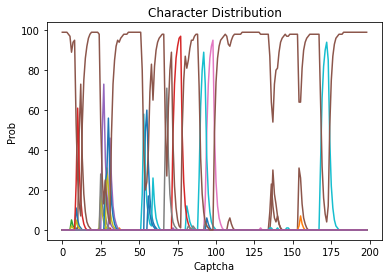

In [33]:
new_dist = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
new_dist = np.array(new_dist)

alpha = 0.5

#initialization stuff
for i in range(0, 36):
    new_dist[i][0] = distribution[i][0]


for i in range(0, 36):
    for j in range(1, len(new_dist[0])):
        new_dist[i][j] = alpha*distribution[i][j] + (1-alpha)*new_dist[i][j-1]


plt.title("Character Distribution")
for ch in range(0, 36):
    plt.plot(range(len(img_windows)), new_dist[ch])
    plt.xlabel("Captcha")
    plt.ylabel("Prob")
plt.show()

# Conventional Alg Part: Bazillionth Attempt 

In [35]:
import scipy.signal

### Without Denoising

In [39]:
chars_str = "abcdefghijklmnopqrstuvwxyz123456789 "
threshold= 0.85
max_prob = torch.max(torch.from_numpy(distribution))
#print(max_prob)
peaks_inf = [[-1 for i in range(len(img_windows))] for j in range(36)]

for i in range(len(chars_str)-1): ##isolate peaks, ignore null
    peak, prop = scipy.signal.find_peaks(x = distribution[i], height = 0.9*max_prob.item())
    for j in range(len(peak)):
        #print(peak[j])
        #print(len(peak))
        #print(j)
        peaks_inf[i][peak[j]] = 1  #indicate peak
        #peaks_inf[peak[j]] = prop["peak_heights"][peak[j]]
    #print(peaks_inf[i])

captcha_str = ''
for k in range(len(img_windows)): # for each column 
    max_val = -1
    max_index = -1
    for x in range(len(chars_str)-1):
        if peaks_inf[x][k] == 1:  #if there even is a peak 
          if distribution[x][k] > max_val: #access indices of distribution 
              max_val = distribution[x][k]
              max_index = x
    if max_val != -1:
        captcha_str = captcha_str + chars_str[max_index]
 
    
print(("captca is: {}").format(captcha_str))

captca is: 8peyja2xjgt


### With Denoising

In [40]:
chars_str = "abcdefghijklmnopqrstuvwxyz123456789 "
threshold= 0.85
max_prob = torch.max(torch.from_numpy(distribution))
#print(max_prob)
peaks_inf = [[-1 for i in range(len(img_windows))] for j in range(36)]

for i in range(len(chars_str)-1): ##isolate peaks, ignore null
    peak, prop = scipy.signal.find_peaks(x = new_dist[i], height = 0.8*max_prob.item())
    for j in range(len(peak)):
        #print(peak[j])
        #print(len(peak))
        #print(j)
        peaks_inf[i][peak[j]] = 1  #indicate peak
        #peaks_inf[peak[j]] = prop["peak_heights"][peak[j]]
    #print(peaks_inf[i])

captcha_str = ''
for k in range(len(img_windows)): # for each column 
    max_val = -1
    max_index = -1
    for x in range(len(chars_str)-1):
        if peaks_inf[x][k] == 1:  #if there even is a peak 
          if new_dist[x][k] > max_val: #access indices of distribution 
              max_val = new_dist[x][k]
              max_index = x
    if max_val != -1:
        captcha_str = captcha_str + chars_str[max_index]
 
    
print(("captca is: {}").format(captcha_str))

captca is: xjgt


# Formalizing and combining stuff

#### P1: Create Functions

In [41]:
# generate windows:
def window_gens(img2):
    img_windows = []
    captcha_w = img2.shape[1]
    transf = transforms.Resize((224, 224))
          
    for i in range(0,captcha_w - window_w):
        #print(c_w)
        new_img = img2[:,i:(window_w+i),:]
        if window_w != 224:
            #new_img = transf(new_img)
            #new_img = cv2.resize(new_img, (0,0 ), fx=224/window_w, fy=224/c_h)
            #print(new_img.shape)


            #new_img = np.tile(new_img, (1,9,1))
            #new_img = new_img[:,:224,:]

            #print(new_img.shape)
            new_img = cv2.resize(new_img, (0,0 ), fx=224/window_w, fy=224/c_h)
        img_windows.append(new_img)
    return img_windows

def get_dist(img_windows):
    distribution = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
    distribution = np.array(distribution)

    #dist_nosm = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
    #dist_nosm = np.array(dist_nosm)

    iter1 = 0
    prob_sum = 0
    for k in range(0, len(img_windows)): # for each window
        img_windows[k] = img_windows[k].cuda()
        pred = model3(img_windows[k])  #pred has shape 1x35 (will change to 36 once null is added)
        #print(len(pred[0]))
        for j in range(0, 36): # for each class
            #print(("k: {} | j: {}").format(k, j))
            
            pred2 = torch.softmax(pred, dim=1) #apply softmax
            if iter1 == 0:
                for pr in range(36):
                    prob_sum = prob_sum + pred2[0][pr]
                #print(("total prob is: {}").format(prob_sum))
                iter1 = iter1 + 1
            #print(pred2[0][j])
            arr = pred2[0][j]*100
            distribution[j][k] = arr

    #print(torch.max(torch.from_numpy(distribution)))
    return distribution


def denoise_dist(distribution, alpha = 0.5):
    new_dist = [[0 for i in range(len(img_windows))] for j in range(36)]  # len(img_windows)x35 to hold all outputs for each window
    new_dist = np.array(new_dist)

    #initialization stuff
    for i in range(0, 36):
        new_dist[i][0] = distribution[i][0]


    for i in range(0, 36):
        for j in range(1, len(new_dist[0])):
            new_dist[i][j] = alpha*distribution[i][j] + (1-alpha)*new_dist[i][j-1]
    
    return new_dist


def get_captcha(new_dist, img_windows):
    chars_str = "abcdefghijklmnopqrstuvwxyz123456789 "
    threshold= 0.85
    max_prob = torch.max(torch.from_numpy(distribution))
    #print(max_prob)
    peaks_inf = [[-1 for i in range(len(img_windows))] for j in range(36)]

    for i in range(len(chars_str)-1): ##isolate peaks, ignore null
        peak, prop = scipy.signal.find_peaks(x = new_dist[i], height = 0.8*max_prob.item())
        for j in range(len(peak)):
            #print(peak[j])
            #print(len(peak))
            #print(j)
            peaks_inf[i][peak[j]] = 1  #indicate peak
            #peaks_inf[peak[j]] = prop["peak_heights"][peak[j]]
        #print(peaks_inf[i])

    captcha_str = ''
    for k in range(len(img_windows)): # for each column 
        max_val = -1
        max_index = -1
        for x in range(len(chars_str)-1):
            if peaks_inf[x][k] == 1:  #if there even is a peak 
              if new_dist[x][k] > max_val: #access indices of distribution 
                  max_val = new_dist[x][k]
                  max_index = x
        if max_val != -1:
            captcha_str = captcha_str + chars_str[max_index]
    return captcha_str
    
#print(("captca is: {}").format(captcha_str))

In [42]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testData = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/APS360Project_Dataset/test1', transform=transform)



FileNotFoundError: ignored

In [52]:
#Modifying Trevor's Script 

class RawSet():
    def __init__(self, size):
        self.size = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    def __getitem__(self, index):
        label = get_random_string(8)
        data = self.IC.generate_image(label)
        data = self.transform(data)
        label = label.lower().replace(" ", "")
        label += " " * (8 - len(label))

        labelTensor = strToInd(label)
        
        return data, labelTensor

    def __len__(self):
        return self.size

In [53]:
test_set = RawSet(100)

In [64]:
for i in range(len(test_set)):
    img = test_set[i][0]
    lbl = test_set[i][1] # this is a tensor

    lbl_str = ''
    for index in range(len(lbl)):
        lbl_str = lbl_str + chars_str[lbl[index]]

    wins = window_gens(np.array(img))
    #print(wins[0].shape)
    #img_to_tensor = transforms.ToTensor()
    #for i in range(0, len(wins)):
    #    wins[i] = img_to_tensor(np.array(wins[i]))

    for i in range(0, len((wins))):
        wins[i] = torch.from_numpy(wins[i]).unsqueeze(0)

    model3.cuda()
    #print(wins[0].shape)
    raw_dist = get_dist(wins)
    d_dist = denoise_dist(raw_dist, alpha = 0.5)
    final_cap = get_captcha(d_dist, wins)

    p_lbl = lbl
    p_cap = final_cap
    for n1 in range(8 - len(lbl)): # pad to make character comparison easier
        p_lbl = p_lbl + " "
    

    for n2 in range(8 - len(final_cap)): # pad to make character comparison easier
        p_cap = p_cap + " "

    #geting accuracy
    correct_chars = 0
    for ch in range(8):
        if p_cap[ch] == p_lbl[ch]:
            correct_chars = correct_chars + 1

    percent_corr = correct_chars/8.0
    print(("Input Captcha (label) was {} | Output Captcha was {} | % characters correct are {}").format(lbl_str, final_cap, percent_corr))
    

Input Captcha (label) was bjs3wm   | Output Captcha was j | % characters correct are 0.0
Input Captcha (label) was gb5no3eh | Output Captcha was rkr | % characters correct are 0.0
Input Captcha (label) was zgqxy7e  | Output Captcha was  | % characters correct are 0.0
Input Captcha (label) was ythwkn18 | Output Captcha was ttttt | % characters correct are 0.0
Input Captcha (label) was fiac4d   | Output Captcha was  | % characters correct are 0.0
Input Captcha (label) was wva7ds6r | Output Captcha was jt | % characters correct are 0.0
Input Captcha (label) was itzmqy   | Output Captcha was  | % characters correct are 0.0
Input Captcha (label) was 1qefsrso | Output Captcha was r | % characters correct are 0.0
Input Captcha (label) was q5nt2del | Output Captcha was tt | % characters correct are 0.0
Input Captcha (label) was bfrmlxb  | Output Captcha was jwp7 | % characters correct are 0.0
Input Captcha (label) was bc4fkra  | Output Captcha was livt | % characters correct are 0.0
Input Capt